In [ ]:
!pip install pyts
!pip install --upgrade pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.5 MB/s eta 0:00:00


In [ ]:

import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.fft import fft, dct
import pywt
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages
import os
from sklearn.metrics.cluster import adjusted_rand_score
from pyts.approximation import PiecewiseAggregateApproximation as PAA
from scipy.fftpack import idct

def generate_random_vectors(n, r):
    random_vectors = np.random.normal(0, 1, size=(r, n))
    return random_vectors

def MINE(data,R,R_inv):
  prod = np.matmul(data,R)
  bitmap = np.where(prod < 0, 0, 1)
  recon = np.matmul(bitmap,R_inv)
  # print('data',data)
  # print('prod',prod)
  # print('bitmap',bitmap)
  # print('recon',recon)
  return recon

def plot_confidence_interval(scores,method,stride,compression,type):
    # compute mean silhouette score and confidence interval
    mean_score = np.mean(scores)
    ci = stats.t.interval(0.95, len(scores)-1, loc=mean_score, scale=stats.sem(scores))

    # 2D array with the lower and upper bounds of the confidence interval
    yerr = np.array([[mean_score-ci[0]], [ci[1]-mean_score]])

    # create the figure and axis objects
    fig, ax = plt.subplots()

    # plot the data with error bars
    ax.plot(scores, marker='o')
    ax.errorbar(x=range(len(scores)), y=scores, yerr=yerr, fmt='none', ecolor='r')

    # set the axis labels and title
    ax.set_xlabel('Number of windows')

    if type == 'SC' :
     ax.set_ylabel('Silhouette score')
     if method == 'RAW':
      ax.set_title(f'Silhouette scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'Silhouette scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')


    if type == 'ARI' :
     ax.set_ylabel('ARI score')
     if method == 'RAW':
      ax.set_title(f'ARI scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'ARI scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')
    # return the figure object
    return fig

def plot_score_confidence_interval(data,window_size,compression):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Adjust the figure size as needed

    colors = ['b', 'g', 'r', 'c', 'm']  # Colors for each method

    y_axis_limits = (-1.5, 1.5)  # Outlier limits

    for i, (scores, method) in enumerate(data):
        ax = axs[i]
        n = len(scores)
        x = np.arange(n) + 1
        y = np.array(scores)

        # Identify and count outliers based on the limits
        outliers = np.where((y < -1.5) | (y > 1.5))[0]
        num_outliers = len(outliers)

        # Exclude outliers from the data
        filtered_scores = np.delete(y, outliers)
        filtered_x = np.delete(x, outliers)

        mean = np.mean(filtered_scores)
        # Calculate the confidence interval
        ci = stats.t.interval(0.95, len(filtered_scores), loc=mean, scale=stats.sem(filtered_scores))
        # Plot the non-outlier data points and mean
        ax.plot(filtered_x, filtered_scores, 'o', markersize=4, color=colors[i])
        ax.plot(x, [mean] * n, '--', color=colors[i])

        fig.suptitle(f'Silhouette scores with 95% confidence interval // W= {window_size}, C= {compression} ')

        ax.set_xlabel('Window')
        ax.set_ylabel('Score')
        ax.set_title(f'{method} : [{ci[0]:.5f}, {ci[1]:.5f}] ')
        ax.grid(True)

        # Set the y-axis limits to the predefined range
        ax.set_ylim(y_axis_limits)

        # Add the number of outliers as text in the top right corner
        ax.text(0.85, 0.9, f'Outliers: {num_outliers}', transform=ax.transAxes, fontsize=10, color='red', ha='right')

    return fig

def plot_ARI_confidence_interval(data,window_size,compression):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Adjust the figure size as needed

    colors = ['b', 'g', 'r', 'c', 'm']  # Colors for each method
    y_axis_limits = (-1.5, 1.5) # Outlier limits

    for i, (scores, method) in enumerate(data):
        ax = axs[i]
        n = len(scores)
        x = np.arange(n) + 1
        y = np.array(scores)
        # Identify and count outliers based on the limits
        outliers = np.where((y < -1.5) | (y > 1.5))[0]
        num_outliers = len(outliers)

        # Exclude outliers from the data
        filtered_scores = np.delete(y, outliers)
        filtered_x = np.delete(x, outliers)

        mean = np.mean(filtered_scores)
        # Calculate the confidence interval
        ci = stats.t.interval(0.95, len(filtered_scores), loc=mean, scale=stats.sem(filtered_scores))

        # Plot the non-outlier data points and mean
        ax.plot(filtered_x, filtered_scores, 'o', markersize=4, color=colors[i])
        ax.plot(x, [mean] * n, '--', color=colors[i])

        fig.suptitle(f'ARI scores with 95% confidence interval // W= {window_size}, C= {compression} ')

        ax.set_xlabel('Window')
        ax.set_ylabel('Score')
        ax.set_title(f'{method} : [{ci[0]:.5f}, {ci[1]:.5f}]')
        ax.grid(True)

        # Set the y-axis limits to the predefined range
        ax.set_ylim(y_axis_limits)

        # Add the number of outliers as text in the top right corner
        ax.text(0.85, 0.9, f'Outliers: {num_outliers}', transform=ax.transAxes, fontsize=10, color='red', ha='right')

    return fig
# Load data

all_temperatures = np.loadtxt("/content/drive/MyDrive/temp.txt", delimiter='\t')
all_humidities = np.loadtxt("/content/drive/MyDrive/humidity.txt", delimiter='\t')
all_lights = np.loadtxt("/content/drive/MyDrive/light.txt", delimiter='\t')
all_voltages = np.loadtxt("/content/drive/MyDrive/voltage.txt", delimiter='\t')

alldata = [all_temperatures.T , all_humidities.T , all_lights.T , all_voltages.T ]
count = 0
for data in alldata:
  # Scale data
  scaler = MinMaxScaler()
  scaled_data = scaler.fit_transform(data)

  # KMeans
  k = 2
  if count == 0:
    k = 4
    dstring = 'Temperatures'
  elif count == 1:
     dstring = 'Humidities'
  elif count == 2:
     dstring = 'Lights'
  elif count == 3:
    dstring = 'Voltages'
  count = count + 1 # so that k value and "dstring" get adjusted
  random_state = 0
  # set up the parameters
  strides = [16, 32, 64, 128]
  compressions = [4, 8, 16]
  methods = ['DFT', 'DCT', 'DWT', 'PAA','MINE']
  n_features = scaled_data.shape[1]
  all_labels = []  # create an empty list to store labels for all strides-ARI

  #file for storing
  folder_name = f"Kmeans {dstring} Measurements(k = {k})"
  if not os.path.exists(folder_name):
    os.makedirs(folder_name)


  raw_folder_name = f"RAW DATA"
  if not os.path.exists(os.path.join(folder_name,raw_folder_name)):
    os.makedirs(os.path.join(folder_name,raw_folder_name))

  pdf_file = os.path.join(folder_name,raw_folder_name, 'plots.pdf')

  with PdfPages(pdf_file, 'a') as pdf:
   for stride in strides:

    silhouette_scores = []
    bad_clusters = 0
    subset_num = 0  #to accurately stroe labels for ARI

    for i in range(0, n_features-stride, stride):


        subset_length = min(stride, n_features-i)
        subset_data = scaled_data[:, i:i+subset_length]
        clustering = KMeans(n_clusters=k, random_state=random_state, n_init=10).fit(subset_data)
        # store clustering results
        labels = clustering.labels_
        score = metrics.silhouette_score(subset_data , clustering.labels_)
        silhouette_scores.append(score)
        all_labels.append((stride, subset_num, labels))  # append the labels for this stride to all_labels
        subset_num = subset_num + 1
    #store plots
    methd = 'RAW'
    comprsn = 0
    fig = plot_confidence_interval(silhouette_scores,methd,stride,comprsn,'SC') #plot function call
    pdf.savefig(fig)
    plt.close(fig)
    # create a file name based on the method, subset index, stride, and compression
    avg_silhouette = np.mean(silhouette_scores)
    file_name = f"RAW DATA_stride({stride}).txt"
    # write the silhouette coefficients to file
    with open(os.path.join(folder_name,raw_folder_name, file_name), 'w+') as f:
      f.write(f"Average Silhouette Score: {avg_silhouette}\n")
      content = str(silhouette_scores)
      f.write(content)
      f.close()

  for stride in strides:

      #file for storing
      stride_folder_name = f"stride({stride})"
      if not os.path.exists(os.path.join(folder_name,stride_folder_name)):
          os.makedirs(os.path.join(folder_name,stride_folder_name))

      for compression in compressions:

          #vector and inverse vector arrays for our algorithm
          n = 64*int(stride/compression)  # Dimension of each random vector
          r = stride  # Number of random vectors to generate/rows
          R = generate_random_vectors(n, r)
          R_inv= np.linalg.pinv(R)
        # print(R.shape,R_inv.shape)

          #files for storing measurements
          compression_folder_name = f"compression({compression})"
          if not os.path.exists(os.path.join(folder_name,stride_folder_name, compression_folder_name)):
              os.makedirs(os.path.join(folder_name,stride_folder_name, compression_folder_name))

          #files for storing plots
          plots_dir = os.path.join(folder_name,stride_folder_name, compression_folder_name, 'plots')
          os.makedirs(plots_dir, exist_ok=True)
          pdf_file = os.path.join(plots_dir, 'plots.pdf')
          with PdfPages(pdf_file, 'a') as pdf:
           results1 = []
           results2 = []
           for method in methods:

              slices = stride // compression
              silhouette_scores = []
              ARI_scores = []
              bad_clusters = 0
              num_subset = 0

              for i in range(0, n_features - stride, stride):

                  #vector and inverse vector arrays for our algorithm
                  # n = 64*int(stride/compression)  # Dimension of each random vector
                  # r = stride  # Number of random vectors to generate/rows
                  # R = generate_random_vectors(n, r)
                  # R_inv= np.linalg.pinv(R)

                  subset_length = min(stride, n_features-i)
                  subset_data = scaled_data[:, i:i+subset_length]

                  if method == 'DFT':

                        #  # Compute abs DFT of each row
                        #  dft_subset_data1 = np.fft.fft(subset_data , axis=1)
                        #  #abs_dft_subset_data = np.abs(dft_subset_data)
                        #  # Sort the DFT coefficients along each row by their magnitude
                        #  sorted_indices1 = np.argsort(np.abs(dft_subset_data1), axis=1)[:, ::-1]
                        #  sorted_dft_subset_data1 = np.take_along_axis(dft_subset_data1, sorted_indices1, axis=1)
                        #  # Keep  top  coeff
                        #  top__dft_subset_data1 = sorted_dft_subset_data1[:, :slices]
                        #  # Pad zeros to make the shape of `top_dft` (48, 16)
                        #  padded_top_dft1 = np.pad(top__dft_subset_data1, [(0, 0), (0, subset_data.shape[1] - slices)], mode='constant')
                        #  #reconstruct the compressed dataset
                        #  compressed_subset_data1 = np.fft.ifft(padded_top_dft1, axis=1).real
                        #  print('be4 dft',subset_data.shape,subset_data[0])
                        #  print('after dft',dft_subset_data1.shape,dft_subset_data1[0])
                        #  print('top dft ',top__dft_subset_data1.shape,top__dft_subset_data1[0])
                        #  print('after',compressed_subset_data1.shape,compressed_subset_data1[0])

                        #array to store the restored data
                        compressed_subset_data = np.zeros_like(subset_data)

                        for i in range(48):
                            # Compute abs DFT of each row
                            dft_subset_data =  np.fft.fft(subset_data[i])
                            # Sort the DFT coefficients along each row by their magnitude
                            sorted_indices = np.argsort(-np.abs(dft_subset_data))[:slices]
                            sorted_dft_subset_data = dft_subset_data[sorted_indices]
                            # Keep  top  coeff
                            top__dft_subset_data = sorted_dft_subset_data[:slices]
                            #reconstruct the compressed dataset
                            compressed_subset_data[i] = np.fft.ifft(top__dft_subset_data,stride).real

                            # print('be4 dft',subset_data[i].shape,subset_data[i])
                            # print('after dft',dft_subset_data.shape,dft_subset_data)
                            # print('sorted_dft_subset_data ',sorted_dft_subset_data.shape,sorted_dft_subset_data )
                            # print('top dft ',top__dft_subset_data.shape,top__dft_subset_data)
                            # print('after',compressed_subset_data[0].shape,compressed_subset_data[0])
                            # dfhdfgh

                        #  print('be4 dft',subset_data.shape,subset_data[0])
                        #  print('after',compressed_subset_data.shape,compressed_subset_data[0])


                  elif method == 'DCT':

                        #  dft_subset_data1 = dct(subset_data , axis=1)
                        #  #abs_dft_subset_data = np.abs(dft_subset_data)
                        #  # Sort the DFT coefficients along each row by their magnitude
                        #  sorted_indices1 = np.argsort(np.abs(dft_subset_data1), axis=1)[:, ::-1]
                        #  sorted_dft_subset_data1 = np.take_along_axis(dft_subset_data1, sorted_indices1, axis=1)
                        #  # Keep  top  coeff
                        #  top__dft_subset_data1 = sorted_dft_subset_data1[:, :slices]
                        #  # Pad zeros to make the shape of `top_dft` (48, 16)
                        #  padded_top_dft1 = np.pad(top__dft_subset_data1, [(0, 0), (0, subset_data.shape[1] - slices)], mode='constant')
                        #  #reconstruct the compressed dataset
                        #  compressed_subset_data1 = idct(padded_top_dft1, axis=1).real
                        #  print('be4 dct',subset_data.shape,subset_data[0])
                        #  print('after dct',dft_subset_data1.shape,dft_subset_data1[0])
                        #  print('top dct ',top__dft_subset_data1.shape,top__dft_subset_data1[0])
                        #  print('after',compressed_subset_data1.shape,compressed_subset_data1[0])

                          #array to store the restored data
                        compressed_subset_data = np.zeros_like(subset_data)

                        for i in range(48):
                            # Compute abs DFT of each row
                            dct_subset_data = dct(subset_data[i])
                            # Sort the DFT coefficients along each row by their magnitude
                            sorted_indices = np.argsort(-np.abs(dct_subset_data))[:slices]
                            sorted_dct_subset_data = dct_subset_data[sorted_indices]
                            # Keep  top  coeff
                            top__dct_subset_data = sorted_dct_subset_data[:slices]
                            compressed_subset_data[i] = idct(top__dct_subset_data, type=2, n=stride).real

                            # print('be4 dct',subset_data[i].shape,subset_data[i])
                            # print('after dct',dct_subset_data.shape,dct_subset_data)
                            # print('top dct ',top__dct_subset_data.shape,top__dct_subset_data)
                            # print('after',compressed_subset_data[0].shape,compressed_subset_data[0])
                            # dfhdfgh

                        #  print('be4 dct',subset_data.shape,subset_data[0])
                        #  print('after',compressed_subset_data.shape,compressed_subset_data[0])
                        #  sedrg

                  elif method == 'DWT':

                        #array to store the restored data
                        compressed_subset_data = np.zeros_like(subset_data)

                        for i in range(48):
                            # Apply DWT to each row using 'db1' wavelet
                            cA, cD = pywt.dwt(subset_data[i], 'db1')
                            # Sort
                            sorted_cD_subset_data = np.zeros_like(cD) #initialize storage array
                            sorted_indices = np.argsort(-np.abs(cD))[:slices]
                            sorted_cD_subset_data[sorted_indices] = cD[sorted_indices]
                            # Perform inverse DWT to restore the row
                            compressed_subset_data[i] = pywt.idwt(cA, sorted_cD_subset_data, 'db1')

                        # print('be4 dWt',subset_data.shape,subset_data[0])
                        # print('cA',cA.shape,cA)
                        # print('sorted ',sorted_cA_subset_data.shape,sorted_cA_subset_data)
                        # print('restored ', compressed_subset_data.shape, compressed_subset_data[0])
                        # rtu

                  elif method == 'PAA':

                        # Apply PAA along the rows of the array
                        paa = PAA(window_size = compression)
                        compressed_subset_data = paa.fit_transform(subset_data)

                  elif method == 'MINE':

                      #array to store the restored data
                      compressed_subset_data = np.zeros_like(subset_data)

                      for i in range(48):
                        row = subset_data[i]
                        # Apply my algorithm along the rows of the array
                        compressed_subset_data[i] = MINE(row,R,R_inv)


                  clustering = KMeans(n_clusters=k, random_state=random_state, n_init=10).fit(compressed_subset_data)

                  # clustering results
                  labels = clustering.labels_
                  score = metrics.silhouette_score(compressed_subset_data , clustering.labels_)
                  silhouette_scores.append(score)
                  original_labels = [labels for strde, subst_num, labels in all_labels if strde == stride and subst_num == num_subset][0]

                  ARI = adjusted_rand_score(original_labels, labels)
                  ARI_scores.append(ARI)
                  num_subset += 1

              results1.append((silhouette_scores, method))
              results2.append((ARI_scores, method))

              # create a file name based on the method, subset index, stride, and compression
              avg_silhouette = np.mean(silhouette_scores)
              file_name = f"{method}_stride({stride})_compression({compression} - SILHOUETTES).txt"
              # write the silhouette coefficients to file
              with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
                f.write(f"Average Silhouette Score: {avg_silhouette}\n")
                content = str(silhouette_scores)
                f.write(content)
                f.close()

              avg_ARI = np.mean(ARI_scores)
              file_name = f"{method}_stride({stride})_compression({compression} - ARIs).txt"
              # write the silhouette coefficients to file
              with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
                f.write(f"Average ARI Score: {avg_ARI}\n")
                content = str(ARI_scores)
                f.write(content)
                f.close()

           #store plots
           fig = plot_score_confidence_interval(results1,stride,compression) #plot function call
           pdf.savefig(fig)
           plt.close(fig)
           fig = plot_ARI_confidence_interval(results2,stride,compression) #plot function call
           pdf.savefig(fig)
           plt.close(fig)


[3 2 1 3 2 0 2 2 0 2 0 0 2 1 0 0 0 0 1 2 2 2 0 2 2 0 1 0 2 1 2 2 2 0 2 2 2
 0 0 2 2 0 2 0 0 0 0 2]
[2 0 3 2 0 3 2 0 3 0 3 1 0 3 3 3 3 1 3 2 0 2 2 0 1 3 3 3 0 3 0 2 2 2 2 1 2
 3 1 1 2 2 2 3 3 3 3 0]


NameError: ignored

In [ ]:
#@title BACKUP
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.fft import fft, dct
import pywt
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages
import os
from sklearn.metrics.cluster import adjusted_rand_score
from pyts.approximation import PiecewiseAggregateApproximation as PAA
from scipy.fftpack import idct

def plot_confidence_interval(scores,method,stride,compression,type):
    # compute mean silhouette score and confidence interval
    mean_score = np.mean(scores)
    ci = stats.t.interval(0.95, len(scores)-1, loc=mean_score, scale=stats.sem(scores))

    # 2D array with the lower and upper bounds of the confidence interval
    yerr = np.array([[mean_score-ci[0]], [ci[1]-mean_score]])

    # create the figure and axis objects
    fig, ax = plt.subplots()

    # plot the data with error bars
    ax.plot(scores, marker='o')
    ax.errorbar(x=range(len(scores)), y=scores, yerr=yerr, fmt='none', ecolor='r')

    # set the axis labels and title
    ax.set_xlabel('Subset of features')

    if type == 'SC' :
     ax.set_ylabel('Silhouette score')
     if method == 'RAW':
      ax.set_title(f'Silhouette scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'Silhouette scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')


    if type == 'ARI' :
     ax.set_ylabel('ARI score')
     if method == 'RAW':
      ax.set_title(f'ARI scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'ARI scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')
    # return the figure object
    return fig


# Load data

all_temperatures = np.loadtxt("/content/drive/MyDrive/temp.txt", delimiter='\t')
all_humidities = np.loadtxt("/content/drive/MyDrive/humidity.txt", delimiter='\t')
all_lights = np.loadtxt("/content/drive/MyDrive/light.txt", delimiter='\t')
all_voltages = np.loadtxt("/content/drive/MyDrive/voltage.txt", delimiter='\t')

data = all_voltages.T

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# KMeans
k = 2      #@param {type:"number"}// 4 gia temps 2 for the rest
random_state = 0
# set up the parameters
strides = [16, 32, 64, 128]
compressions = [4, 8, 16]
methods = ['DFT']#, 'DCT', 'DWT', 'PAA']
n_features = scaled_data.shape[1]
all_labels = []  # create an empty list to store labels for all strides-ARI

#file for storing
folder_name = f"Kmeans test Measurements(k = {k})"
if not os.path.exists(folder_name):
   os.makedirs(folder_name)


raw_folder_name = f"RAW DATA"
if not os.path.exists(os.path.join(folder_name,raw_folder_name)):
   os.makedirs(os.path.join(folder_name,raw_folder_name))

pdf_file = os.path.join(folder_name,raw_folder_name, 'plots.pdf')

with PdfPages(pdf_file, 'a') as pdf:
 for stride in strides:

   silhouette_scores = []
   bad_clusters = 0
   subset_num = 0  #to accurately stroe labels for ARI

   for i in range(0, n_features-stride, stride):


      subset_length = min(stride, n_features-i)
      subset_data = scaled_data[:, i:i+subset_length]
      clustering = KMeans(n_clusters=k, random_state=random_state, n_init=10).fit(subset_data)
      # store clustering results
      labels = clustering.labels_
      score = metrics.silhouette_score(subset_data , clustering.labels_)
      silhouette_scores.append(score)
      all_labels.append((stride, subset_num, labels))  # append the labels for this stride to all_labels
      subset_num = subset_num + 1
   #store plots
   methd = 'RAW'
   comprsn = 0
   fig = plot_confidence_interval(silhouette_scores,methd,stride,comprsn,'SC') #plot function call
   pdf.savefig(fig)
   plt.close(fig)
   # create a file name based on the method, subset index, stride, and compression
   avg_silhouette = np.mean(silhouette_scores)
   file_name = f"RAW DATA_stride({stride}).txt"
   # write the silhouette coefficients to file
   with open(os.path.join(folder_name,raw_folder_name, file_name), 'w+') as f:
    f.write(f"Average Silhouette Score: {avg_silhouette}\n")
    content = str(silhouette_scores)
    f.write(content)
    f.close()

for stride in strides:

    #file for storing
    stride_folder_name = f"stride({stride})"
    if not os.path.exists(os.path.join(folder_name,stride_folder_name)):
        os.makedirs(os.path.join(folder_name,stride_folder_name))

    for compression in compressions:

        #files for storing measurements
        compression_folder_name = f"compression({compression})"
        if not os.path.exists(os.path.join(folder_name,stride_folder_name, compression_folder_name)):
            os.makedirs(os.path.join(folder_name,stride_folder_name, compression_folder_name))

        #files for storing plots
        plots_dir = os.path.join(folder_name,stride_folder_name, compression_folder_name, 'plots')
        os.makedirs(plots_dir, exist_ok=True)
        pdf_file = os.path.join(plots_dir, 'plots.pdf')
        with PdfPages(pdf_file, 'a') as pdf:
         for method in methods:

             slices = stride // compression
             silhouette_scores = []
             ARI_scores = []
             bad_clusters = 0
             num_subset = 0

             for i in range(0, n_features - stride, stride):
                 subset_length = min(stride, n_features-i)
                 subset_data = scaled_data[:, i:i+subset_length]

                 if method == 'DFT':

                       # Compute abs DFT of each row of X_train
                       dft_subset_data = np.fft.fft(subset_data , axis=1)
                       abs_dft_subset_data = np.abs(dft_subset_data)
                       # Sort ROWS
                       sorted_dft_subset_data = np.sort(abs_dft_subset_data, axis=1)[:, ::-1]
                       # Keep  top  coeff
                       top__dft_subset_data = sorted_dft_subset_data[:, :slices]
                       #reconstruct the compressed dataset
                       compressed_subset_data = np.fft.ifft(top__dft_subset_data, axis=1).real

                       print('be4 dft',subset_data.shape,subset_data[0])
                       print('after dft',dft_subset_data.shape,dft_subset_data[0])
                       print('top dft ',top__dft_subset_data.shape,top__dft_subset_data[0])
                       print('after',compressed_subset_data.shape,compressed_subset_data[0])
                       dtyyjtyjk
                 elif method == 'DCT':

                       # Compute abs DFT of each row of X_train
                       dct_subset_data = dct(subset_data , axis=1)
                       abs_dct_subset_data = np.abs(dct_subset_data)
                       # Sort ROWS
                       sorted_dct_subset_data = np.sort(abs_dct_subset_data, axis=1)[:, ::-1]
                       # Keep  top  coeff
                       top__dct_subset_data = sorted_dct_subset_data[:, :slices]
                       #reconstruct the compressed dataset
                       compressed_subset_data = idct(top__dct_subset_data, axis=1).real


                 elif method == 'DWT':

                     # Apply DWT to X_train_scaled
                      cA, cD = pywt.dwt(subset_data, 'db1', axis=1)
                      # Sort ROWS
                      sorted_cA = np.sort(np.abs(cA), axis=1)[:, ::-1]
                      # select biggest coefficients
                      top_compressed = sorted_cA[:, :slices]
                      # Reconstruct original data
                      compressed_subset_data = pywt.idwt(top_compressed, None, 'db1')


                 elif method == 'PAA':

                      # Apply PAA along the rows of the array
                      paa = PAA(window_size = compression)
                      compressed_subset_data = paa.fit_transform(subset_data)


                 clustering = KMeans(n_clusters=k, random_state=random_state, n_init=10).fit(compressed_subset_data)

                 # clustering results
                 labels = clustering.labels_
                 score = metrics.silhouette_score(compressed_subset_data , clustering.labels_)
                 silhouette_scores.append(score)
                 original_labels = [labels for strde, subst_num, labels in all_labels if strde == stride and subst_num == num_subset][0]
                 ARI = adjusted_rand_score(original_labels, labels)
                 ARI_scores.append(ARI)
                 num_subset += 1

             #store plots
             fig = plot_confidence_interval(silhouette_scores,method,stride,compression,'SC') #plot function call
             pdf.savefig(fig)
             fig = plot_confidence_interval(ARI_scores,method,stride,compression,'ARI') #plot function call
             pdf.savefig(fig)
             plt.close(fig)
             # create a file name based on the method, subset index, stride, and compression
             avg_silhouette = np.mean(silhouette_scores)
             file_name = f"{method}_stride({stride})_compression({compression} - SILHOUETTES).txt"
             # write the silhouette coefficients to file
             with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
              f.write(f"Average Silhouette Score: {avg_silhouette}\n")
              content = str(silhouette_scores)
              f.write(content)
              f.close()

             avg_ARI = np.mean(ARI_scores)
             file_name = f"{method}_stride({stride})_compression({compression} - ARIs).txt"
             # write the silhouette coefficients to file
             with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
              f.write(f"Average ARI Score: {avg_ARI}\n")
              content = str(ARI_scores)
              f.write(content)
              f.close()



In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.fft import fft, dct
import pywt



def paa(data, n_pieces):
    """
    Piecewise Aggregate Approximation (PAA) on data.
    """
    n = data.shape[0]
    piece_length = int(np.ceil(n/n_pieces))
    padded_data = np.pad(data, ((0, piece_length*n_pieces-n), (0,0)), mode='constant', constant_values=0)
    pieces = padded_data.reshape(n_pieces, piece_length, -1)
    return np.mean(pieces, axis=1)

# Load data

all_temperatures = np.loadtxt("/content/drive/MyDrive/temp.txt", delimiter='\t')
all_humidities = np.loadtxt("/content/drive/MyDrive/humidity.txt", delimiter='\t')
all_lights = np.loadtxt("/content/drive/MyDrive/light.txt", delimiter='\t')
all_voltages = np.loadtxt("/content/drive/MyDrive/voltage.txt", delimiter='\t')

data = all_temperatures.T

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# KMeans
k = 4       #@param {type:"number"}
random_state = 0
method = 4 #@param {type:"number"}0=RAW, 1=DFT , 2=DCT, 3=discrete wavelet transform , 4=PAA

n_features = scaled_data.shape[1]
stride = 128 #@param {type:"number"}
silhouette_scores = []
n_labels = []
noise_points = []
clusters = []
bad_clusters = 0
compression = 4 #@param {type:"number"}
slices = stride // compression

for i in range(0, n_features, stride):
    subset_length = min(stride, n_features-i)
    subset_data = scaled_data[:, i:i+subset_length]
    if method == 1:
        subset_data = subset_data.T # ginotan compression stis seires anti gia tis stiles
        subset_transform = np.abs(fft(subset_data, axis=0))
        subset_transform = np.sort(subset_transform, axis=0)[::-1][:slices]
        subset_transform = subset_transform.T
        #print(subset_transform.shape)
        print_string = 'DFT'
    elif method == 2:
        subset_data = subset_data.T
        subset_transform = dct(subset_data, axis=0)
        subset_transform = np.sort(subset_transform, axis=0)[::-1][:slices]
        subset_transform = subset_transform.T
        #print(subset_transform.shape)
        print_string = 'DCT'
    if method == 3:
        subset_data = subset_data.T
        cA, cD = pywt.dwt(subset_data, 'db1', axis=0)
        subset_transform = np.concatenate((cA, cD), axis=0)
        subset_transform = np.sort(subset_transform, axis=0)[::-1][:slices]
        subset_transform = subset_transform.T
        print_string = 'DWT'
    elif method == 4:
        subset_transform = paa(subset_data.T, n_pieces=slices)
        subset_transform = subset_transform.T
        print_string = 'PAA'
    elif method == 0:
        subset_transform = subset_data
        print_string = 'RAW'
    print('here')
    print(subset_transform.shape)
    clustering = KMeans(n_clusters=k, random_state=random_state, n_init=10).fit(subset_transform)

    #clustering results
    labels = clustering.labels_

    if len(set(labels)) >= 1:
        noise_points.append(list(labels).count(-1))
        score =  metrics.silhouette_score(subset_transform , clustering.labels_)
        silhouette_scores.append(score)
        n_labels.append(clustering.labels_.size)
    else:
        bad_clusters += 1
        print(f"No clusters found for subset {i//stride + 1} using {print_string} method. Labels: {labels}")

# Print silhouette scores and number of labels
print(f"Silhouette scores and number of labels for each {stride} subset of features:")
for i, (score, n) in enumerate(zip(silhouette_scores, n_labels)):
    print(f"Subset {i}: Silhouette score={score:.5f}, Number of labels={n}")
# Print  number of bad clusters
print(f"Number of subsets where clustering was not possible: {bad_clusters}")

#plot
from scipy import stats
import matplotlib.pyplot as plt

# mean silhouette score and confidence interval
mean_score = np.mean(silhouette_scores)
ci = stats.t.interval(0.95, len(silhouette_scores)-1, loc=mean_score, scale=stats.sem(silhouette_scores))

# 2D array with the lower and upper bounds of the confidence interval
yerr = np.array([[mean_score-ci[0]], [ci[1]-mean_score]])

# Plot the data with error bars
fig, ax = plt.subplots()
ax.plot(silhouette_scores, marker='o')
ax.errorbar(x=range(len(silhouette_scores)), y=silhouette_scores, yerr=yerr, fmt='none', ecolor='r')
ax.set_xlabel('Subset of features')
ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette scores with 95% confidence interval')
plt.show()

print(f"95% confidence interval: [{ci[0]:.5f}, {ci[1]:.5f}]")

# Saving the scores array in a text file
file_name = f"Kmeans,window({stride}),method({print_string}),compressed by {slices}.txt"
file = open(file_name, "w+")
content = str(silhouette_scores)
file.write(content)
file.close()

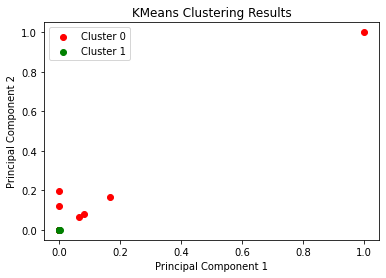

In [ ]:

# Plot the results
colors = ['red', 'green', 'blue', 'orange']  # one color per cluster
for i in range(k):
    plt.scatter(scaled_data[clustering.labels_ == i, 0],
                scaled_data[clustering.labels_ == i, 1],
                color=colors[i],
                label='Cluster %d' % i)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering Results')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

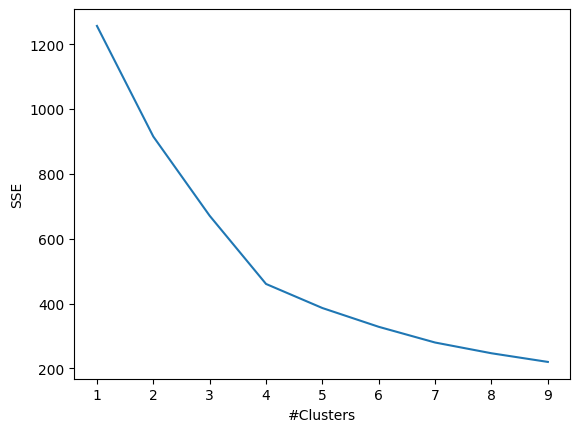

In [ ]:
import matplotlib.pyplot as plt
sse = {}
for k in range(1, 10):
    clustering = KMeans(n_clusters=k, max_iter=1000).fit(scaled_data)
    sse[k] = clustering.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("#Clusters")
plt.ylabel("SSE")
plt.show()